<a href="https://colab.research.google.com/github/bill7845/project_brunchNetworking_streamlit/blob/master/preprocessing/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## colab에서 konlpy 사용

In [ ]:
# !apt-get update
# !apt-get install g++ openjdk-8-jdk 
# !pip3 install konlpy

In [ ]:
## colab에서 mecab 사용

In [ ]:
# ! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [ ]:
# cd Mecab-ko-for-Google-Colab/

In [ ]:
# ! bash install_mecab-ko_on_colab190912.sh

In [ ]:
## library import
import pandas as pd
import numpy as np
import json
import os
import pickle
import urllib.request
import re
from konlpy.tag import Okt
from konlpy.tag import Mecab

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
dir_name = '/content/drive/My Drive/Colab code/brunch_project/data/basement/json' ## ~~path~~

def get_file_list(dir_name): # file name들을 가져오는 함수 # 폴더명 인자 # 폴더가 위치한 경로를 인자로
    return os.listdir(dir_name) # 폴더 내 파일명을 리스트 형태로 반환 

file_list = get_file_list(dir_name)

# \n, 공백 제거 후 리스트 형식으로 변환 
def pre_keyword(x):
    tmp = []
    for val in x:
        tmp.append(val.replace("\n","").replace(" ",""))
    return tmp

# comment가 없는경우 공백이 아닌 Nan으로 변환
def pre_comment(x):
    if len(x) == 0:
        return None
    else :
        return x
#  문자열로 변환
def pre_text(x):
    return str(x)

# datetime형식으로 변환
def pre_datetime(x):
    x = x.split('T')[0]
    x = pd.to_datetime(x,format="%Y-%m-%d")
    return x


## 전체 json 파일을 DataFrame으로 합친 후, 전처리 ##
all_df = pd.DataFrame(columns=['class','text'])
each_df = {}
class_name = []

for file in file_list:
    with open('/content/drive/My Drive/Colab code/brunch_project/data/basement/json/'+file,encoding='UTF8') as json_file:
        json_data = json.load(json_file)

    class_name.append(file[:-5])
    
    df = pd.DataFrame(json_data['data'],
                  columns=['title','keyword','text','nickname','publish_date','likes','share','comment','url','url_plink'])
    df = df.dropna(subset=['text'])
    df['keyword'] = df['keyword'].apply(pre_keyword)
    df['comment'] = df['comment'].apply(pre_comment)
    df['text'] = df['text'].apply(pre_text)
    df['publish_date'] = df['publish_date'].apply(pre_datetime)
    df.insert(0,"class",file[:-5])

    all_df = pd.concat([all_df,df[['class','title','text','keyword','likes','share','comment','publish_date','url']]])
    each_df[file[:-5]] = df

## class encoding
to_categorical = [i for i in range(18)]
class_condition = {}
for a,b in zip(class_name,to_categorical):
  class_condition[a] = b

all_df['ori_class'] = all_df['class']
all_df['class'] = all_df['class'].map(class_condition)
all_df = all_df.reset_index(drop=True)


## 불용어 제거
import re
def pre_text_2(x):
  pa = re.compile("^\\\\xa0|xa")
  pa1 = re.compile(r"'http.*?'") # 전체 url 제거
  pa2 = re.compile(r'\([^)]*\)') # () 사이 문자 
  pa3 = re.compile('[^\w\s]') # 특수문자 삭제
  pa4 = re.compile(r'[^a-zA-Zㄱ-힗]')

  x = re.sub(pa,' ',x)
  x = re.sub(pa1,' ',x)
  x = re.sub(pa2,' ',x)
  x = re.sub(pa3, ' ',x)
  x = re.sub(pa4, ' ',x)
  x = x.strip()
  x = " ".join(x.split())
  return x 
all_df['text'] = all_df['text'].apply(pre_text_2)

In [ ]:
## 길이 500자 이하 게시글 제거
del_list = []
for idx,text in enumerate(all_df['text']):
  if len(text) < 500:
    del_list.append(idx)

all_df = all_df.loc[~all_df.index.isin(del_list), :]

In [ ]:
## 중복 문서 제거
print("전체 문서 : ", len(all_df['text']))
print("중복 문서 : ", len(all_df['text']) - all_df['text'].nunique())

all_df.drop_duplicates(subset=['text'], inplace=True) # 중복문서 제거
print("중복 제거 후 전체 문서 :", len(all_df['text']))

all_df = all_df.reset_index(drop=True) # index 초기화 

전체 문서 :  192353
중복 문서 :  17549
중복 제거 후 전체 문서 : 174804


class 결측값 :  0
14    15110
9     14704
8     14667
0     14207
13    13167
10    12892
16    11027
17    10062
12     9592
15     9353
7      8339
3      7926
11     7397
2      6562
5      6471
6      5316
1      4193
4      3819
Name: class, dtype: int64


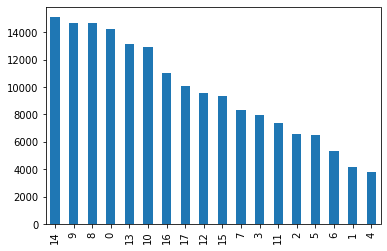

In [ ]:
## 전처리 후 class별 결측값 여부 및 분포 확인
print('class 결측값 : ',all_df['class'].isnull().sum())
print(all_df['class'].value_counts())
all_df['class'].value_counts().plot(kind='bar')

In [ ]:
# 전체 DataFrame 저장

all_df.to_csv('/content/drive/My Drive/Colab code/brunch_project/data/basement/all_df_pText.csv') # 추가 전처리 완료
all_df = pd.read_csv('/content/drive/My Drive/Colab code/brunch_project/data/basement/all_df_pText.csv') # 추가 전처리 완료

In [ ]:
## keyword 기반 추천 ##
## 각 게시글별 keyword를 벡터화하여 저장 ##
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

all_df['keyword_literal'] = all_df['keyword'].apply(lambda x : (' ').join(x)) # keyword vector => ["keyword1, keyword2, keyword3.."]
keyword_count_vect = CountVectorizer() 
keyword_mat = keyword_count_vect.fit_transform(all_df['keyword_literal']) # CountVectorizer로 벡터화


path = '/content/drive/My Drive/Colab code/brunch_project/data/vect'
# vector 저장
pickle.dump(keyword_count_vect, open(os.path.join(path,'keyword_count_vect.pkl'),'wb'),
            protocol=4)
# matrix 저장 
pickle.dump(keyword_mat, open(os.path.join(path,'keyword_mat.pkl'),'wb'),
            protocol=4)

In [ ]:
## 문서기반 추천 ## 
## 18개 카테고리별(class별) vector와 matrix 생성하여 저장

from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Mecab
from tqdm.notebook import tqdm

mecab = Mecab()
def to_matrix_eachCategory(df):
  for category in df['class'].unique():
    each_text = all_df[all_df['class'] == category]['text']
    each_text = each_text.values.tolist()

    train_data = []
    tmp = None
    for idx in tqdm(range(len(each_text))):
        tmp = [i[0] for i in mecab.pos(each_text[idx]) if ( ((i[1]=="NNG") or (i[1]=="NNP")) and(len(i[0])>1))] # 품사가 명사이면서, 길이가 1이상
        train_data.append(" ".join(tmp))

    tfidf_vect = TfidfVectorizer(max_df=0.9)
    tfidf_vect.fit(train_data)
    tfidf_matrix = tfidf_vect.transform(train_data)

    path = '/content/drive/My Drive/Colab code/brunch_project/data/vect/each_vect'
    pickle.dump(tfidf_vect, open(os.path.join(path,str(category)+'tfidf_vect.pkl'),'wb'),protocol=4)

    path = '/content/drive/My Drive/Colab code/brunch_project/data/vect/each_matrix'
    pickle.dump(tfidf_matrix, open(os.path.join(path,str(category)+'tfidf_matrix.pkl'),'wb'),protocol=4)

to_matrix_eachCategory(all_df)

In [ ]:
# 전체 데이터셋을 train/test로 분할하여 저장
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(all_df[['text']],all_df['class'],test_size=0.2,random_state=0,stratify=all_df['class']) 
# X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=0, stratify=y_train) # validation 데이터 필요할 경우

X_train = X_train['text'].values.tolist()
X_test = X_test['text'].values.tolist()
# X_val = X_val['text'].values.tolist()

path = '/content/drive/My Drive/Colab code/brunch_project/data/vect'
pickle.dump(X_train, open(os.path.join(path,'X_train.pkl'),'wb'),
            protocol=4)
pickle.dump(X_test, open(os.path.join(path,'X_test.pkl'),'wb'),
            protocol=4)
# pickle.dump(X_val, open(os.path.join(path,'X_val.pkl'),'wb'),
#             protocol=4)

pickle.dump(y_train, open(os.path.join(path,'y_train.pkl'),'wb'),
            protocol=4)
pickle.dump(y_test, open(os.path.join(path,'y_test.pkl'),'wb'),
            protocol=4)
# pickle.dump(y_val, open(os.path.join(path,'y_val.pkl'),'wb'),
#             protocol=4)

# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/X_train.pkl', 'rb') as f:
#   X_train = pickle.load(f) 
# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/X_test.pkl', 'rb') as f:
#   X_test = pickle.load(f)
# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/X_val.pkl', 'rb') as f:
  # X_val = pickle.load(f)

# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/y_train.pkl', 'rb') as f:
#   y_train = pickle.load(f) 
# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/y_test.pkl', 'rb') as f:
#   y_test = pickle.load(f)
# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/y_val.pkl', 'rb') as f:
  # y_val = pickle.load(f)

In [ ]:
from konlpy.tag import Mecab
from tqdm.notebook import tqdm

## Mecab의 품사태깅(pos)로 길이가 2이상인 명사만 추출
mecab_pos_tagger = Mecab()

train_data = []
tmp = None
for idx in tqdm(range(len(X_train))):
    tmp = [i[0] for i in mecab_pos_tagger.pos(X_train[idx]) if ( ((i[1]=="NNG") or (i[1]=="NNP")) and(len(i[0])>1))] # 품사가 명사이면서, 길이가 2이상
    train_data.append(" ".join(tmp))

test_data = []
tmp = None
for idx in tqdm(range(len(X_test))):
    tmp = [i[0] for i in mecab_pos_tagger.pos(X_test[idx]) if ( ((i[1]=="NNG") or (i[1]=="NNP")) and(len(i[0])>1))] # 품사가 명사이면서, 길이가 2이상
    test_data.append(" ".join(tmp))

# val_data = []
# tmp = None
# for idx in tqdm(range(len(X_val))):
#     tmp = [i[0] for i in mecab_pos_tagger.pos(X_val[idx]) if ( ((i[1]=="NNG") or (i[1]=="NNP")) and(len(i[0])>1))] # 품사가 명사이면서, 길이가 2이상
#     val_data.append(" ".join(tmp))


path = '/content/drive/My Drive/Colab code/brunch_project/data/vect'
pickle.dump(train_data, open(os.path.join(path,'train_data_mecab_pos2len.pkl'),'wb'),
            protocol=4)
pickle.dump(test_data, open(os.path.join(path,'test_data_mecab_pos2len.pkl'),'wb'),
            protocol=4)
# pickle.dump(val_data, open(os.path.join(path,'val_data_mecab_pos2len.pkl'),'wb'),
            # protocol=4)

# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/train_data_mecab_pos2len.pkl', 'rb') as f:
#   train_data = pickle.load(f) 
# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/test_data_mecab_pos2len.pkl', 'rb') as f:
#   test_data = pickle.load(f)
# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/val_data_mecab_pos2len.pkl', 'rb') as f:
#   val_data = pickle.load(f)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
tfidf_train_matrix = tfidf_vect.fit_transform(train_data) # matrix 저장
tfidf_test_matrix = tfidf_vect.transform(test_data) ## test matrix 저장
# tfidf_val_matrix = tfidf_vect.transform(val_data) ## validation matrix 저장

# ## tfidf_vect_mecab_pos_mindf005 => mecab, pos(길이2이상명사) , min_df=0.05
# ## tfidf_vect_mecab_pos_len2 => mecab, pos(길이2이상명사)
# ##tfidf_vect_mecab_pos_ngram => mecab, pos(길이2이상명사) , ngram(1,2)
# ##tfidf_vect_mecab_ngram_extraction => mecab, pos(길이2이상명사), ngram 추출법으로 차원줄임 , 빈도수10이상

path = '/content/drive/My Drive/Colab code/brunch_project/data/vect'
pickle.dump(tfidf_vect, open(os.path.join(path,'tfidf_vect_mecab_pos_len2.pkl'),'wb'),
            protocol=4)
pickle.dump(tfidf_train_matrix, open(os.path.join(path,'tfidf_train_matrix_mecab_pos_len2.pkl'),'wb'),
            protocol=4)
pickle.dump(tfidf_test_matrix, open(os.path.join(path,'tfidf_test_matrix_mecab_pos_len2.pkl'),'wb'),
            protocol=4)
# pickle.dump(tfidf_val_matrix, open(os.path.join(path,'tfidf_val_matrix_mecab_pos_ngram.pkl'),'wb'),
#             protocol=4)

# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/tfidf_train_matrix_mecab_pos_ngram.pkl', 'rb') as f:
  # tfidf_train_matrix = pickle.load(f) 
# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/tfidf_test_matrix_mecab_pos_ngram.pkl', 'rb') as f:
  # tfidf_test_matrix = pickle.load(f)
# with open('/content/drive/My Drive/Colab code/brunch_project/data/vect/tfidf_val_matrix_mecab_pos_ngram.pkl', 'rb') as f:
  # tfidf_val_matrix = pickle.load(f)

In [ ]:
##################################################
############ n_gram extraction ###################
##################################################

In [ ]:
############ n_gram extraction

from collections import defaultdict
mecab_pos_tagger = Mecab()
# n_gram 반환
def to_ngrams(words, n): # pos tagging된 리스트, n_gram범위
    ngrams = []
    for b in range(0, len(words) - n + 1): # 시작점 b부터 뒤 n개의 단어를 취하고 이를 tuple로 만듦
        ngrams.append(tuple(words[b:b+n]))
    return ngrams # [(n개씩 ngram),(),()....]


docs = X_train
def get_ngram_counter(docs, min_count=5, n_range=(1,2)): #빈도수 10이상의 ngram range(1,2)의 ngram 반환
    n_begin, n_end = n_range
    ngram_counter = defaultdict(int)
    for doc in docs:
        # words = mecab_pos_tagger.pos(doc, join=True)
        words = [i[0] for i in mecab_pos_tagger.pos(doc) if ( ((i[1]=="NNG") or (i[1]=="NNP")) and(len(i[0])>1))]
        for n in range(n_begin, n_end + 1):
            for ngram in to_ngrams(words, n):
                ngram_counter[ngram] += 1

    ngram_counter = {
        ngram:count for ngram, count in ngram_counter.items()
        if count >= min_count
    }

    return ngram_counter

ngram_counter = get_ngram_counter(docs) # ngram_counter 에는 uni, bi, tri-grams 이 함께 섞여 있습니다.

In [ ]:
class NgramTokenizer:

    def __init__(self, ngrams, base_tokenizer, n_range=(1, 2)):
        self.ngrams = ngrams
        self.base_tokenizer = base_tokenizer
        self.n_range = n_range

    def __call__(self, sent):
        return self.tokenize(sent)

    def tokenize(self, sent):
        if not sent:
            return []

        # unigrams = self.base_tokenizer.pos(sent, join=True)
        unigrams = [i[0] for i in self.base_tokenizer.pos(sent) if ( ((i[1]=="NNG") or (i[1]=="NNP")) and(len(i[0])>1))]

        n_begin, n_end = self.n_range
        ngrams = []
        for n in range(n_begin, n_end + 1):
            for ngram in self._to_ngrams(unigrams, n):
                ngrams.append('-'.join(ngram))
        return ngrams

    def _to_ngrams(self, words, n):
      ngrams = []
      for b in range(0, len(words) - n + 1):
          ngram = tuple(words[b:b+n])
          if ngram in self.ngrams:
              ngrams.append(ngram)
      return ngrams

ngram_tokenizer = NgramTokenizer(ngram_counter, mecab_pos_tagger)

In [ ]:
tfidf_vect = TfidfVectorizer(tokenizer=ngram_tokenizer,lowercase = False)

tfidf_train_matrix = tfidf_vect.fit_transform(X_train)
tfidf_test_matrix = tfidf_vect.transform(X_test)
tfidf_val_matrix = tfidf_vect.transform(X_val)

In [ ]:
# import pickle
# import os

path = '/content/drive/My Drive/Colab code/brunch_project/data/vect'
pickle.dump(tfidf_vect, open(os.path.join(path,'tfidf_vect_mecab_ngram_extraction.pkl'),'wb'),
            protocol=4)
pickle.dump(tfidf_train_matrix, open(os.path.join(path,'tfidf_train_matrix_mecab_ngram_extraction.pkl'),'wb'),
            protocol=4)
pickle.dump(tfidf_test_matrix, open(os.path.join(path,'tfidf_test_matrix_mecab_ngram_extraction.pkl'),'wb'),
            protocol=4)
pickle.dump(tfidf_val_matrix, open(os.path.join(path,'tfidf_val_matrix_mecab_ngram_extraction.pkl'),'wb'),
            protocol=4)

In [ ]:
def get_ngram_score(ngram_counter, delta=30):
    ngrams_ = {}
    for ngram, count in ngram_counter.items():
        if len(ngram) == 1:
            continue
        first = ngram_counter[ngram[:-1]]
        second = ngram_counter[ngram[1:]]
        score = (count - delta) / (first * second)
        if score > 0:
            ngrams_[ngram] = (count, score)
    return ngrams_

ngram_scores = get_ngram_score(ngram_counter)